In [3]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.0 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.


In [4]:
import os
import cv2
import json
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO
import warnings
warnings.filterwarnings("ignore")

# Global setup
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
DATASET_DIR = "/kaggle/input/scface/SCface_database"
OUTPUT_DIR = "/kaggle/working"
YOLO_PATH = os.path.join(OUTPUT_DIR, "datasets/dataset")
os.makedirs(YOLO_PATH, exist_ok=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Exploration

## Load metadata

In [5]:
features_path = os.path.join(DATASET_DIR, "features.txt")
with open(features_path, 'r') as f:
    lines = [line.strip() for line in f if line.strip() and '=' not in line]
header = lines[0].split()
rows = [line.split() for line in lines[1:] if len(line.split()) == 6]
df = pd.DataFrame(rows, columns=header)

## Clean metadata

In [6]:
df['BIRTH.YEAR'] = pd.to_datetime(df['BIRTH.YEAR'].str.rstrip('.'), format='%d.%m.%Y')
df['IDs'] = df['IDs'].astype(int)
for col in ['G', 'B', 'M', 'Gl']:
    df[col] = df[col].astype(int)
df = df.rename(columns={
    'IDs': 'ID',
    'BIRTH.YEAR': 'birthday',
    'G': 'gender',
    'B': 'beard',
    'M': 'moustache',
    'Gl': 'glasses'
})
df['age'] = 2009 - df['birthday'].dt.year

## Collect image metadata

In [7]:
image_data = []
for d in [1, 2, 3]:
    dist_folder = os.path.join(DATASET_DIR, f"surveillance_cameras_distance_{d}")
    for cam_num in range(1, 6):
        cam_folder = os.path.join(dist_folder, f"cam_{cam_num}")
        if os.path.exists(cam_folder):
            for filename in os.listdir(cam_folder):
                if filename.endswith(".jpg"):
                    try:
                        file_id, cam, dist = filename.replace('.jpg', '').split('_')
                        img_path = os.path.join(cam_folder, filename)
                        img = cv2.imread(img_path)
                        if img is None:
                            continue
                        h, w, _ = img.shape
                        image_data.append({'id': int(file_id), 'camera': int(cam.replace('cam', '')), 'distance': int(dist), 'path': img_path, 'resolution': (w, h)})
                    except:
                        continue
images_df = pd.DataFrame(image_data)
images_df = images_df.sort_values(by=['id', 'camera', 'distance']).reset_index(drop=True)
merged_df = images_df.merge(df, left_on='id', right_on='ID')

## Plot age distribution

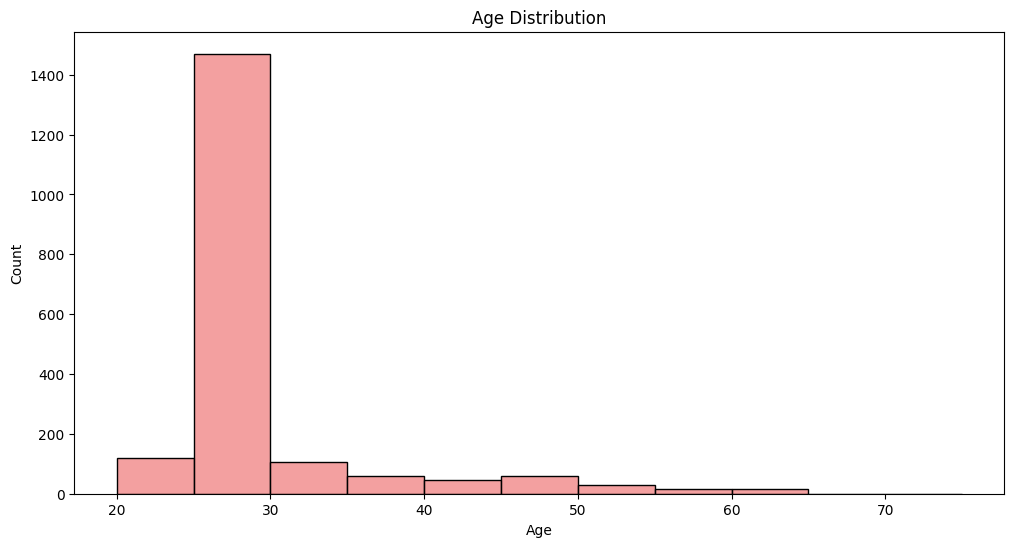

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['age'], bins=range(20, 80, 5), color='lightcoral')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig("age_distribution.png")
plt.show()

## Plot gender distribution

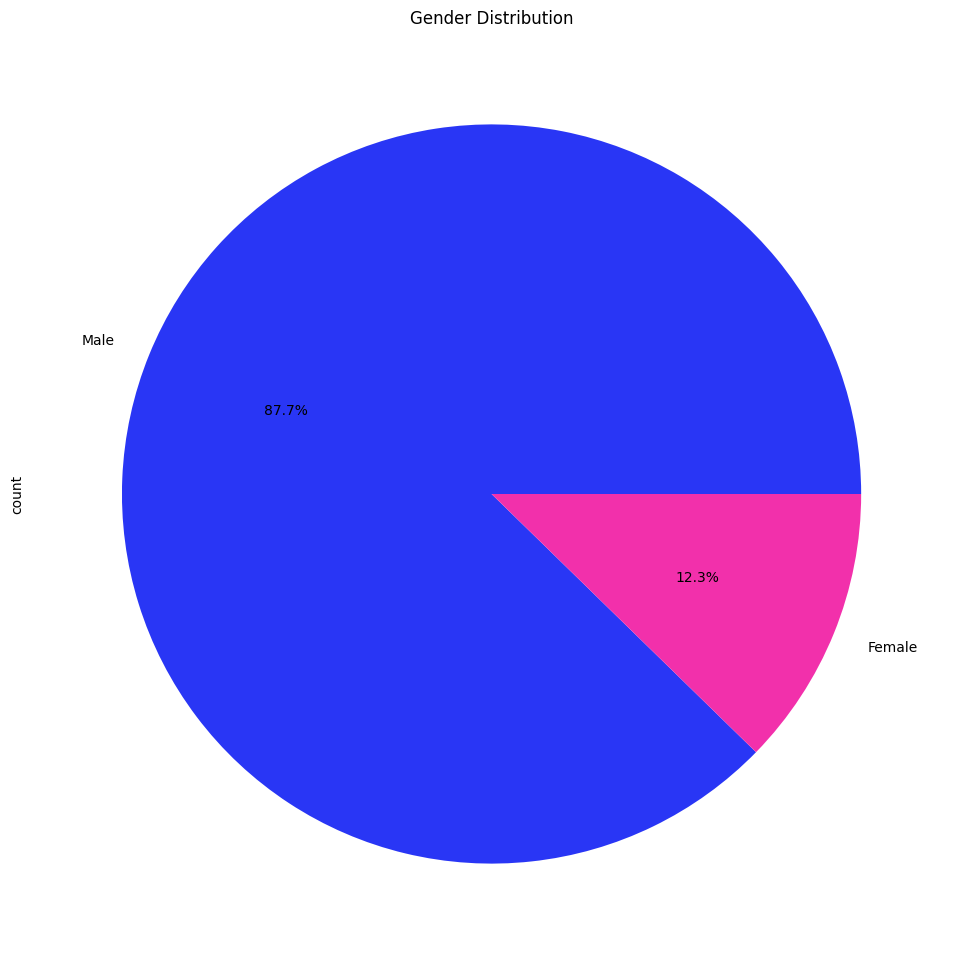

In [9]:
plt.figure(figsize=(12, 12))
merged_df['gender'].value_counts().plot.pie(autopct="%1.1f%%",
                                            labels=['Male', 'Female'],
                                            colors=['#2936F5',"#F230AB"]
                                           )
plt.title("Gender Distribution")
plt.savefig("gender_distribution.png")
plt.show()

## Males with beard vs without

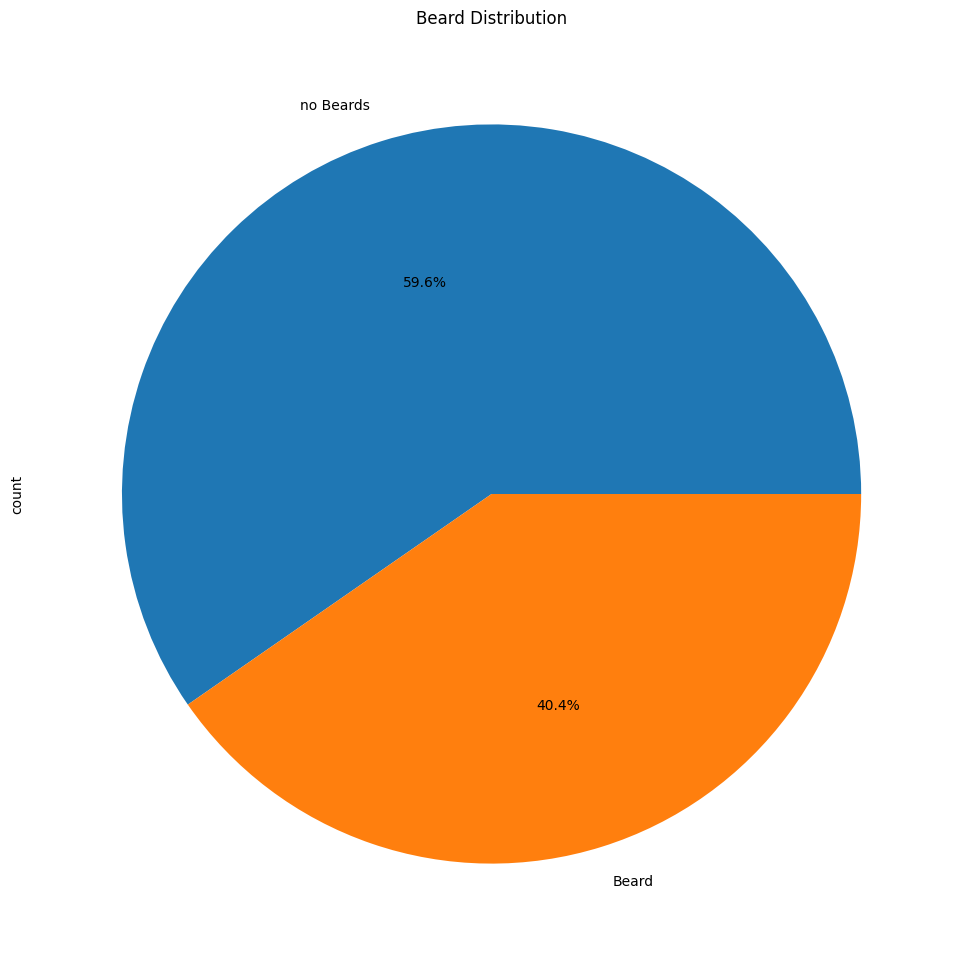

In [10]:
plt.figure(figsize=(12,12))
(merged_df[merged_df['gender'] == 0]['beard'].value_counts()).plot.pie(autopct = "%1.1f%%",
                                                         labels=['no Beards','Beard'])
plt.title('Beard Distribution')
plt.savefig("beard_distribution.png")
plt.show()

## Males with moustache vs without

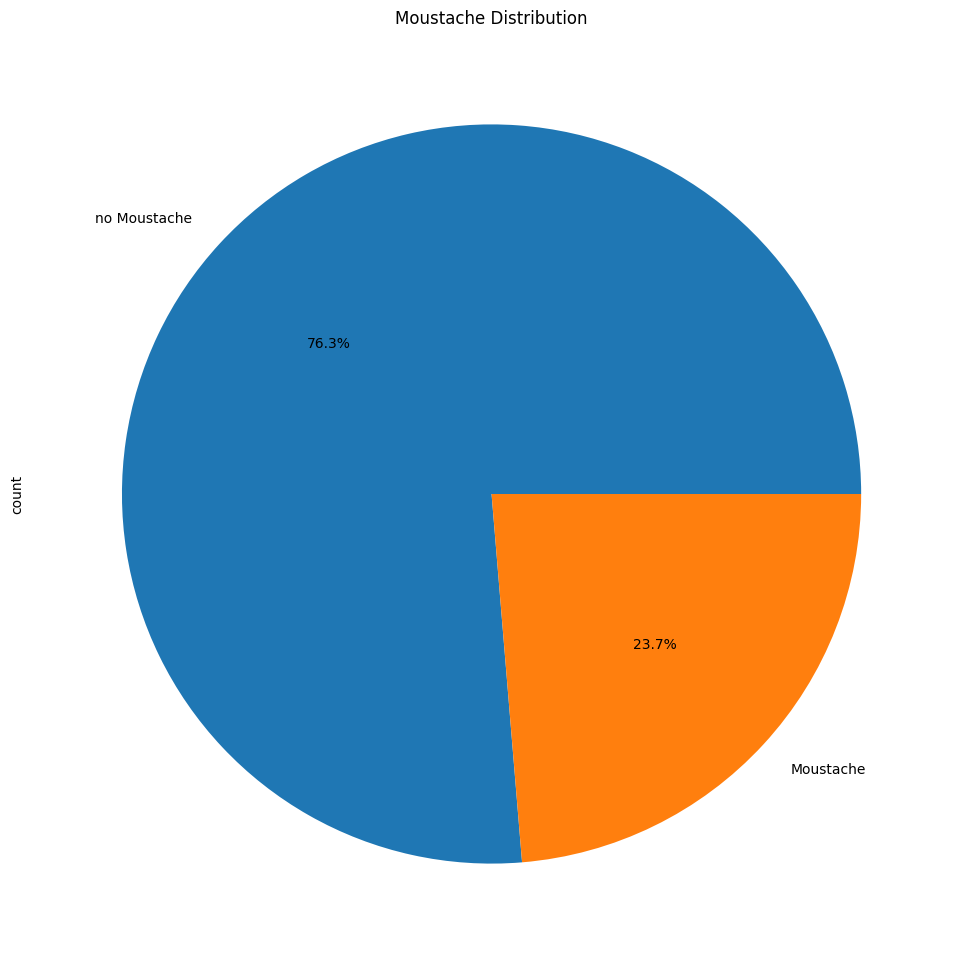

In [11]:
plt.figure(figsize=(12,12))
(merged_df[merged_df['gender'] == 0]['moustache'].value_counts()).plot.pie(autopct = "%1.1f%%",
                                                             labels=['no Moustache','Moustache'])
plt.title('Moustache Distribution')
plt.savefig("moustache_distribution.png")
plt.show()

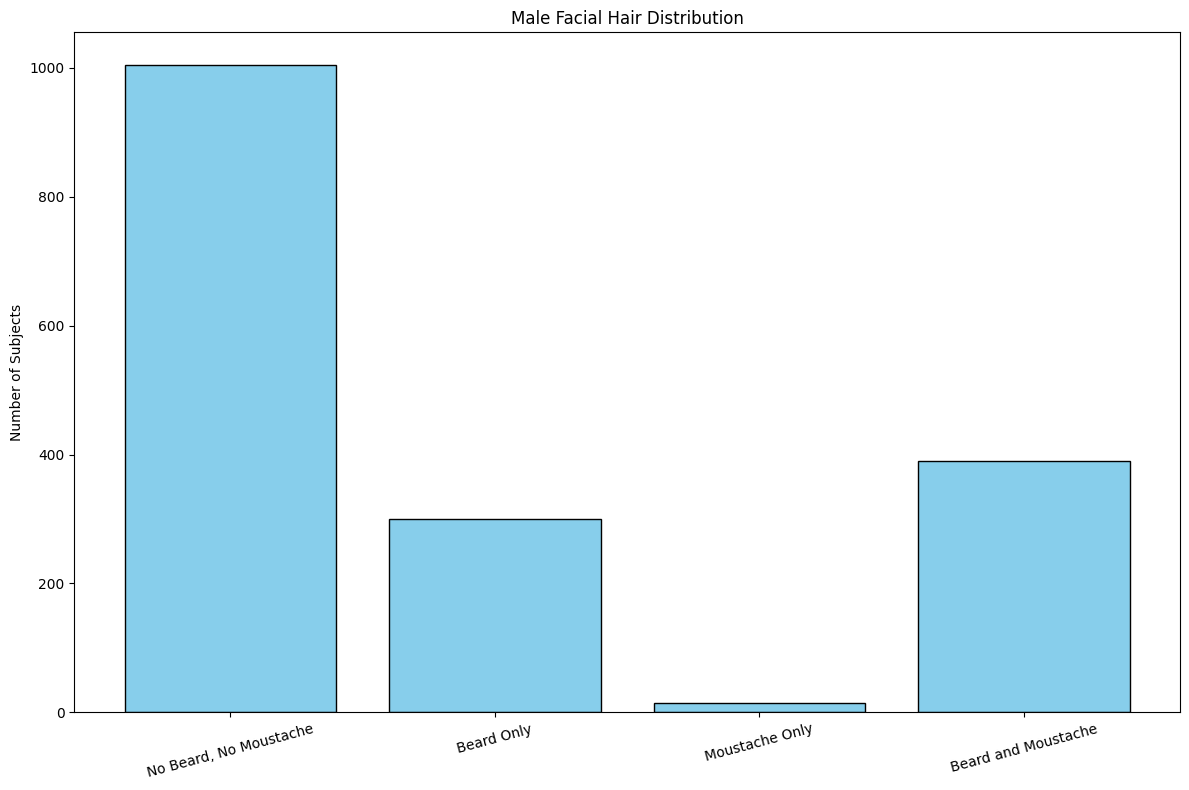

In [12]:
# Filter only males
males = merged_df[merged_df['gender'] == 0]

# Create categories
categories = {
    'No Beard, No Moustache': ((males['beard'] == 0) & (males['moustache'] == 0)).sum(),
    'Beard Only': ((males['beard'] == 1) & (males['moustache'] == 0)).sum(),
    'Moustache Only': ((males['beard'] == 0) & (males['moustache'] == 1)).sum(),
    'Beard and Moustache': ((males['beard'] == 1) & (males['moustache'] == 1)).sum()
}

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.bar(categories.keys(), categories.values(), color='skyblue', edgecolor='black')
plt.title('Male Facial Hair Distribution')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Check image quality

In [13]:
print("Image Resolutions:")
print(merged_df['resolution'].value_counts())
print("\nTotal Images:", len(merged_df))
print("Female Images:", (merged_df['gender'] == 1).sum())
print("Glasses Present:", (merged_df['glasses'] == 1).sum())
print("Bearded Males:", (merged_df[merged_df['gender'] == 0]['beard'] == 1).sum())

Image Resolutions:
resolution
(75, 100)     650
(108, 144)    650
(168, 224)    650
Name: count, dtype: int64

Total Images: 1950
Female Images: 240
Glasses Present: 315
Bearded Males: 690


# Preprocessing and Saving

## Balance gender

In [14]:
target_ratio = 0.25
female_df = merged_df[merged_df['gender'] == 1]
required = int((target_ratio * len(merged_df) - len(female_df)) / (1 - target_ratio))
oversampled_females = female_df.sample(n=required, replace=True, random_state=42)
balanced_df = pd.concat([merged_df, oversampled_females], ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)

## Plot gender distribution after balancing

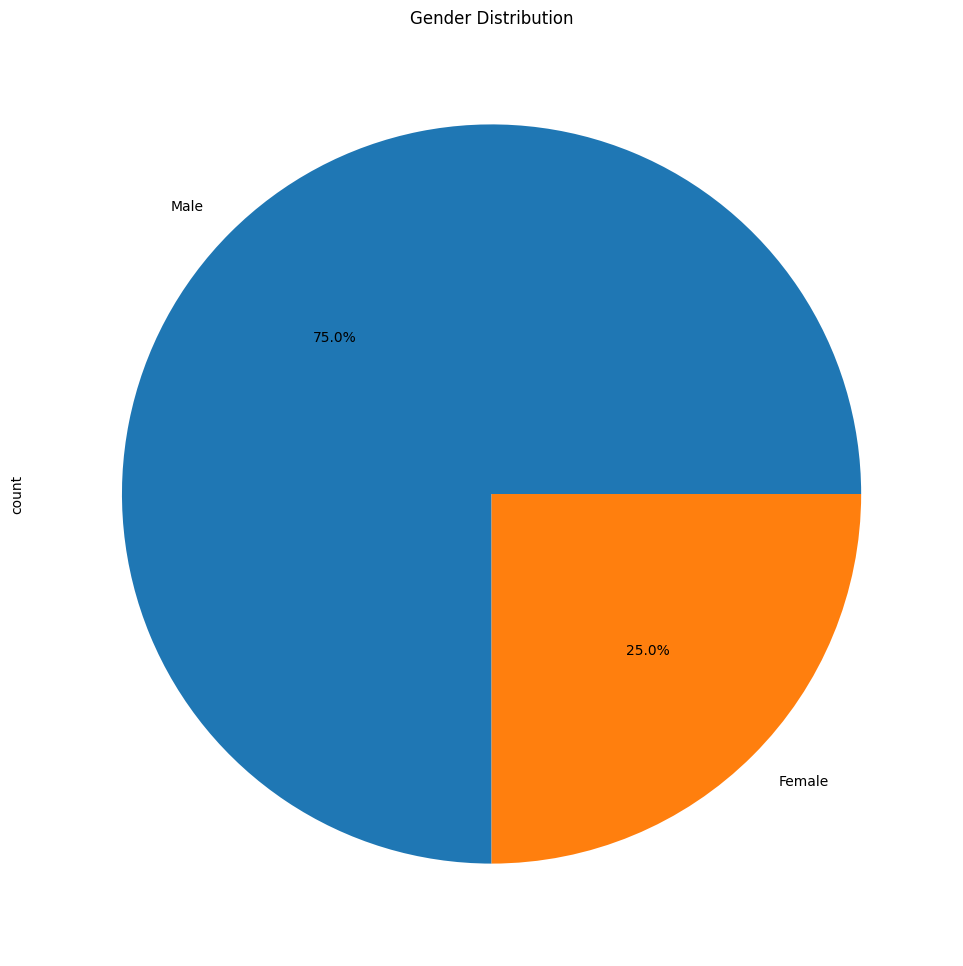

In [15]:
plt.figure(figsize=(12, 12))
balanced_df['gender'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Male', 'Female'])
plt.title("Gender Distribution")
plt.savefig("gender_distribution.png")
plt.show()

## Label encoding

In [16]:
le = LabelEncoder()
balanced_df['encoded_label'] = le.fit_transform(balanced_df['id'])
label_map = dict(zip(le.classes_.astype(str), le.transform(le.classes_).tolist()))
with open(os.path.join(OUTPUT_DIR, "label_map.json"), "w") as f:
    json.dump(label_map, f)

## Split

In [17]:
df_train, df_temp = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['encoded_label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['encoded_label'], random_state=42)

### Save YOLO format

In [18]:
for split, df in zip(['train', 'val', 'test'], [df_train, df_val, df_test]):
    for _, row in df.iterrows():
        img = cv2.imread(row['path'])
        if img is None: continue
        img = cv2.resize(img, (416, 416))
        img_out_path = os.path.join(YOLO_PATH, f"images/{split}/{os.path.basename(row['path'])}")
        label_path = img_out_path.replace("images", "labels").replace(".jpg", ".txt")
        os.makedirs(os.path.dirname(img_out_path), exist_ok=True)
        os.makedirs(os.path.dirname(label_path), exist_ok=True)
        cv2.imwrite(img_out_path, img)
        with open(label_path, "w") as f:
            f.write(f"{row['encoded_label']} 0.5 0.5 1.0 1.0\n")

### Save CNN npz

In [19]:
X, y = [], []
for _, row in balanced_df.iterrows():
    img = cv2.imread(row['path'])
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (416, 416))
    img = img / 255.0
    X.append(img)
    y.append(row['encoded_label'])
X, y = np.array(X, dtype=np.float32), np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

np.savez_compressed(os.path.join(OUTPUT_DIR, "train_cnn.npz"), X=X_train, y=y_train)
np.savez_compressed(os.path.join(OUTPUT_DIR, "val_cnn.npz"), X=X_val, y=y_val)
np.savez_compressed(os.path.join(OUTPUT_DIR, "test_cnn.npz"), X=X_test, y=y_test)

### Save YOLO YAML

In [20]:
with open(os.path.join(YOLO_PATH, "data.yaml"), "w") as f:
    f.write(f"path: {YOLO_PATH}\n")
    f.write(f"train: {YOLO_PATH}/images/train\n")
    f.write(f"val: {YOLO_PATH}/images/val\n")
    f.write(f"test: {YOLO_PATH}/images/test\n")
    f.write(f"nc: {len(set(y))}\n")
    f.write(f"names: {[f'class_{i}' for i in range(len(set(y)))]}\n")

# Models

## YOLO

In [21]:
model_yolo = YOLO("yolo11s.pt")
model_yolo.train(
    data=os.path.join(YOLO_PATH, "data.yaml"),
    epochs=30,
    imgsz=416,
    batch=32,
    device=device,
    name="yolov11s_face",
    amp=True,
    patience=3
)
model_yolo.export(format="onnx")

100%|██████████| 18.4M/18.4M [00:00<00:00, 139MB/s] 


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/datasets/dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s_face, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=3, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, r

100%|██████████| 755k/755k [00:00<00:00, 26.1MB/s]


Overriding model.yaml nc=80 with nc=130

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralyti

100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 875.7±388.6 MB/s, size: 28.8 KB)


train: Scanning /kaggle/working/datasets/dataset/labels/train... 1413 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1413/1413 [00:00<00:00, 1526.78it/s]

train: New cache created: /kaggle/working/datasets/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 818.3±394.1 MB/s, size: 33.4 KB)


val: Scanning /kaggle/working/datasets/dataset/labels/val... 331 images, 0 backgrounds, 0 corrupt: 100%|██████████| 331/331 [00:00<00:00, 1997.65it/s]

val: New cache created: /kaggle/working/datasets/dataset/labels/val.cache


Plotting labels to runs/detect/yolov11s_face/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=7.5e-05, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/yolov11s_face
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         4G     0.6469          5      1.316         13        416: 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


                   all        331        331    0.00431       0.63     0.0177     0.0176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.28G     0.1553       4.26      1.021         12        416: 100%|██████████| 45/45 [00:13<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


                   all        331        331     0.0129      0.746     0.0426     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.28G     0.1246      3.848     0.9886         16        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


                   all        331        331      0.513     0.0799     0.0609     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.28G     0.1094      3.514      0.968         20        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        331        331      0.524      0.182      0.151      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.28G     0.1035       3.21     0.9529         14        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


                   all        331        331      0.593      0.244      0.277      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.28G    0.09687      2.929     0.9395         17        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


                   all        331        331      0.545      0.328      0.352      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.28G     0.0901      2.693     0.9321         13        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


                   all        331        331      0.539      0.464      0.517      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.28G    0.08495      2.487     0.9295         16        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


                   all        331        331      0.763      0.469      0.614      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.28G    0.08099      2.287     0.9211         14        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


                   all        331        331       0.84      0.537      0.698      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.28G    0.08163      2.121     0.9185         20        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        331        331      0.818      0.652      0.773      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.28G    0.07417      1.989     0.9123         16        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        331        331      0.779      0.688      0.799      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.28G    0.07364      1.854      0.911         18        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        331        331      0.848      0.716      0.833      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.28G    0.07028      1.772     0.9059         15        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        331        331       0.89      0.715      0.883      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.28G    0.06923      1.693     0.9129         12        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


                   all        331        331      0.839      0.777      0.884      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.28G    0.06861      1.576     0.9085         16        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        331        331      0.818      0.862      0.932      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.28G    0.06636      1.512      0.904         14        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        331        331      0.808      0.896      0.956      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.28G    0.06579      1.495     0.9026         16        416: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        331        331      0.813      0.882      0.951      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.28G    0.06287      1.438     0.9037         20        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        331        331      0.817      0.934      0.967      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.28G    0.06336      1.375     0.9018         11        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        331        331      0.866      0.895      0.962      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.28G    0.06373      1.361     0.9029         13        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        331        331      0.883      0.921      0.975      0.975


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.28G    0.06559     0.8371     0.9163          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        331        331      0.868      0.936      0.971      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.28G    0.05212     0.6637     0.9152          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        331        331      0.896      0.938      0.975      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.28G    0.04843     0.5727      0.911          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        331        331      0.934      0.951      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.28G    0.04694     0.5429     0.9015          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        331        331      0.943      0.959       0.99       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.28G    0.04336     0.5221     0.9026          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


                   all        331        331      0.938      0.969      0.992      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.28G    0.04099     0.4734     0.8989          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        331        331      0.954      0.967      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.28G    0.03827     0.4377     0.9108          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        331        331      0.959      0.976      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.28G    0.03829     0.4273     0.8965          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all        331        331      0.961      0.983      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.28G    0.03637     0.4103     0.9065          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        331        331      0.966       0.98      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.28G    0.03632     0.4163     0.9027          5        416: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all        331        331      0.969       0.98      0.992      0.992
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 27, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



30 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/yolov11s_face/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/yolov11s_face/weights/best.pt, 19.2MB

Validating runs/detect/yolov11s_face/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,463,110 parameters, 0 gradients, 21.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


                   all        331        331      0.966       0.98      0.994      0.994
               class_0          2          2      0.943          1      0.995      0.995
               class_1          3          3      0.987          1      0.995      0.995
               class_2          2          2      0.963          1      0.995      0.995
               class_3          2          2      0.918          1      0.995      0.995
               class_4          2          2       0.96          1      0.995      0.995
               class_5          2          2       0.95          1      0.995      0.995
               class_6          4          4      0.973          1      0.995      0.995
               class_7          3          3      0.963          1      0.995      0.995
               class_8          2          2      0.947          1      0.995      0.995
               class_9          3          3      0.973          1      0.995      0.995
              class_1

'runs/detect/yolov11s_face/weights/best.onnx'


image 1/1 /kaggle/working/datasets/dataset/images/val/128_cam1_3.jpg: 416x416 1 class_127, 9.3ms
Speed: 0.9ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


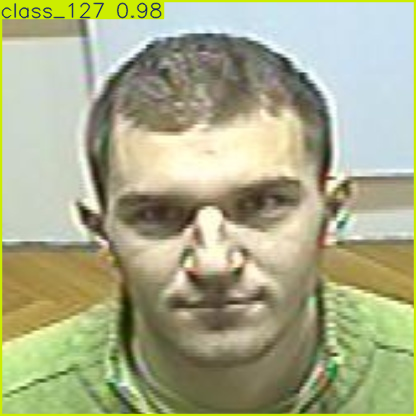

YOLOv10 Prediction complete.


In [41]:
def infer_yolo(image_path):
    model = YOLO(os.path.join(OUTPUT_DIR, "/kaggle/working/runs/detect/yolov11s_face/weights/best.pt"))
    results = model.predict(source=image_path, save=False, device=device)
    results[0].show()
    print("YOLOv10 Prediction complete.")

infer_yolo("/kaggle/working/datasets/dataset/images/val/128_cam1_3.jpg")

## ResNet50

In [46]:
class FaceDatasetCNN(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = (self.images[idx] * 255).astype(np.uint8)
        label = self.labels[idx]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        return image, label

train_data = np.load(os.path.join(OUTPUT_DIR, "train_cnn.npz"))
val_data = np.load(os.path.join(OUTPUT_DIR, "val_cnn.npz"))
X_train, y_train = train_data["X"], train_data["y"]
X_val, y_val = val_data["X"], val_data["y"]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(FaceDatasetCNN(X_train, y_train, transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(FaceDatasetCNN(X_val, y_val, transform_val), batch_size=32)

model_ResNet = models.resnet50(pretrained=True)
model_ResNet.fc = torch.nn.Linear(model_ResNet.fc.in_features, len(np.unique(y_train)))
model_ResNet = model_ResNet.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_acc = 0.0
for epoch in range(50):
    model_ResNet.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_ResNet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = correct / total

    model_ResNet.eval()
    val_total, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ResNet(images)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}: Train Acc = {acc:.4f}, Val Acc = {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_ResNet.state_dict(), os.path.join(OUTPUT_DIR, "resnet50_best.pth"))
    scheduler.step()


Epoch 1: Train Acc = 0.0056, Val Acc = 0.0058
Epoch 2: Train Acc = 0.0050, Val Acc = 0.0175
Epoch 3: Train Acc = 0.0050, Val Acc = 0.0292
Epoch 4: Train Acc = 0.0194, Val Acc = 0.0205
Epoch 5: Train Acc = 0.0194, Val Acc = 0.0380
Epoch 6: Train Acc = 0.0395, Val Acc = 0.0643
Epoch 7: Train Acc = 0.0589, Val Acc = 0.0936
Epoch 8: Train Acc = 0.0877, Val Acc = 0.1082
Epoch 9: Train Acc = 0.1347, Val Acc = 0.1901
Epoch 10: Train Acc = 0.2030, Val Acc = 0.2427
Epoch 11: Train Acc = 0.2281, Val Acc = 0.2690
Epoch 12: Train Acc = 0.2212, Val Acc = 0.3041
Epoch 13: Train Acc = 0.2187, Val Acc = 0.3158
Epoch 14: Train Acc = 0.2011, Val Acc = 0.2047
Epoch 15: Train Acc = 0.2456, Val Acc = 0.2865
Epoch 16: Train Acc = 0.2870, Val Acc = 0.2865
Epoch 17: Train Acc = 0.3947, Val Acc = 0.4181
Epoch 18: Train Acc = 0.4919, Val Acc = 0.4064
Epoch 19: Train Acc = 0.5608, Val Acc = 0.4795
Epoch 20: Train Acc = 0.6654, Val Acc = 0.5292
Epoch 21: Train Acc = 0.7500, Val Acc = 0.6404
Epoch 22: Train Acc = 

## Faster R-CNN

In [45]:
from torchvision.ops import box_iou

def calculate_accuracy(preds, targets, iou_threshold=0.5):
    correct = 0
    total = 0
    for pred, target in zip(preds, targets):
        if len(pred["boxes"]) == 0:
            continue
        ious = box_iou(pred["boxes"].cpu(), target["boxes"].cpu())
        for i in range(min(len(pred["labels"]), len(target["labels"]))):
            if ious[i][i] >= iou_threshold and pred["labels"][i] == target["labels"][i]:
                correct += 1
            total += 1
    return correct, total

for epoch in range(50):
    model_frnn.train()
    total_train_loss = 0.0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model_frnn(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Validation
    model_frnn.eval()
    total_val_loss = 0.0
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
            # Force loss computation in eval mode
            model_frnn.train()
            loss_dict = model_frnn(images, targets)
            model_frnn.eval()
    
            loss = sum(loss for loss in loss_dict.values())
            total_val_loss += loss.item()
    
            preds = model_frnn(images)  # predictions
            correct, total = calculate_accuracy(preds, targets)
            val_correct += correct
            val_total += total
            
    val_acc = val_correct / val_total if val_total > 0 else 0
    print(f"Epoch {epoch+1}: Train Loss = {total_train_loss:.4f}, Val Loss = {total_val_loss:.4f}, Val Acc = {val_acc:.4f}")

KeyboardInterrupt: 